# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1]:
import pandas as pd
import numpy as np
import math
import json
import math


%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:

#thanks Udacity course
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1), dums], axis=1)
        except:
            print(col)
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        if isinstance(i, float) == False:
            for n in i:
                if n not in column_names:
                    column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    series = series.fillna('mk162rl8619')
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def get_years(date_int):
    string = str(date_int)
    short = string[0:4]
    year = int(short)
    year = 2020 - year
    return(year)


def new_offer_id(col1, col2):
    new_col = []
    for i in range(len(col1)):
        if isinstance(col1[i], str):
            new_col.append(col1[i])
            if isinstance(col2[i], str):
                print('doubleval')
        elif isinstance(col2[i], str):
            new_col.append(col2[i])
            if isinstance(col1[i], str):
                print('doubleval')
        else:
            new_col.append(col1[i])
    if len(new_col) == len(col1):
        return(new_col)
    else:
        print('fail')
        

def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
    return encoded


In [ ]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
  
    
    df['interact'] = [1 if i > 0 else  0 for i in df['event_offer completed']]
    user_item_df = df[['offer_id', 'user_id', 'interact']]
    user_item_gb = user_item_df.groupby(['user_id','offer_id'])['interact'].max().unstack(fill_value = float('nan'))
    user_item = pd.DataFrame(user_item_gb)

    return user_item # return the user_item matrix 

In [3]:
tpr_df = transcript.merge(profile, left_on = 'person', right_on = 'id')
#density of 118 year olds makes it seem likely that this is some kind of missingness in the data that should be disregarded
tpr_clean = tpr_df[~(tpr_df['age'] == 118)].reset_index(drop = True)

In [4]:
value_df = pd.DataFrame(list(tpr_clean['value']))
offer_ids = new_offer_id(value_df['offer id'], value_df['offer_id']) 

value_df = value_df.drop(['offer id', 'offer_id', 'reward'], axis = 1)
value_df['offer_id'] = offer_ids

value_df = value_df.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'left')


df = pd.concat([tpr_clean, value_df], axis = 1)
df = df.drop(['value'], axis = 1)

In [5]:
person_encoded = mapper('person')
del df['person']
del df['id']
df['user_id'] = person_encoded

#nas were set to 2
offer_encoded = mapper('offer_id')
del df['offer_id']
df['offer_id'] = offer_encoded

# show header
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,2
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,2


In [6]:
df['offer_id'] = df['offer_id'].replace(2, float('nan'))
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN


In [7]:
df.sort_values(['user_id', 'time'], axis = 0).reset_index(drop = True)

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,offer viewed,504,M,47,20171013,94000.0,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,14824,7.0
272758,offer received,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272759,offer viewed,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272760,offer received,576,F,58,20161020,78000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14825,11.0


In [8]:
channels_df = list_to_cols(df['channels'])
df = df.drop(['channels'],axis = 1)

In [9]:
df['years_member'] = df['became_member_on'].apply(get_years)
df = df.drop(['became_member_on'],axis = 1)

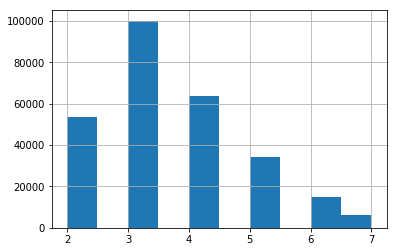

In [10]:
df['years_member'].hist()

#most people are two this data is probably older

In [12]:
for_cats_df = df.select_dtypes(include=['object'])

cats_df = create_dummy_df(df, for_cats_df.columns, False)

In [13]:
new_df = pd.concat([cats_df, channels_df], axis = 1)


df_gb = new_df.groupby(['user_id', 'offer_id']).agg('mean')

df_gb = df_gb.reset_index()
df_gb.head()

,user_id,offer_id,time,age,income,amount,reward,difficulty,duration,years_member,...,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational,web,email,mobile,social
0,1,1.0,46.0,75.0,100000.0,NaN,5.0,5.0,7.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,1,3.0,192.0,75.0,100000.0,NaN,0.0,0.0,3.0,3.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
2,1,4.0,442.0,75.0,100000.0,NaN,10.0,10.0,7.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
3,1,5.0,532.0,75.0,100000.0,NaN,5.0,5.0,5.0,3.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0
4,2,1.0,450.0,68.0,70000.0,NaN,5.0,5.0,7.0,2.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AFFE15B828>,
      dtype=object)

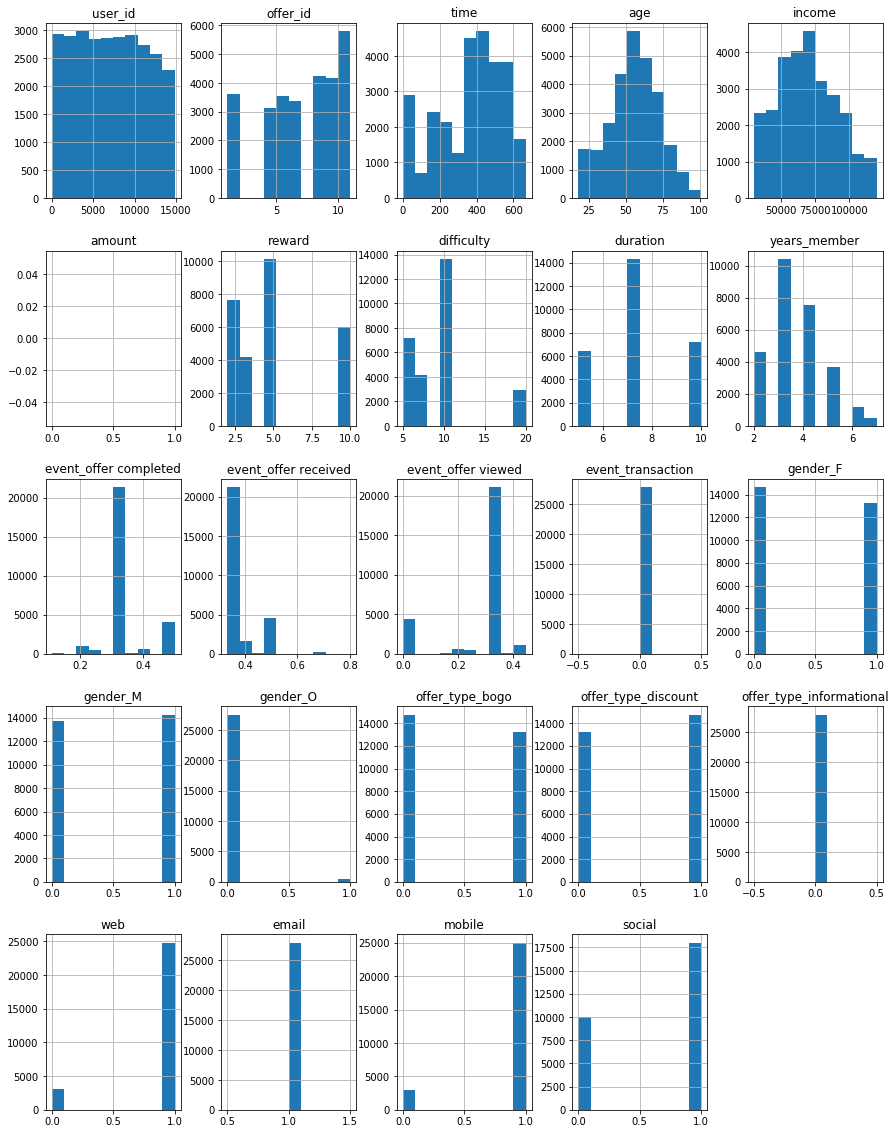

In [14]:
df_gb[df_gb['event_offer completed'] > 0].hist(figsize = (15,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001AFFE6A0828>,
      dtype=object)

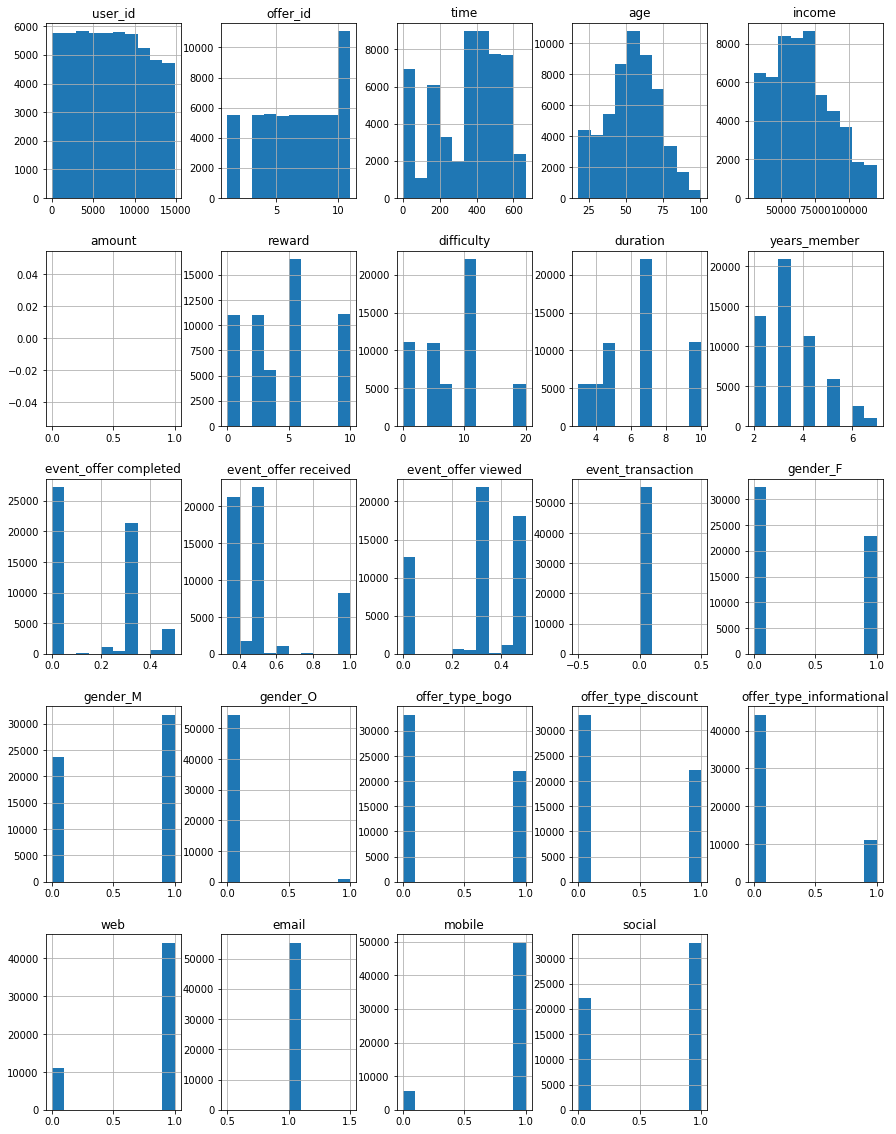

In [15]:
df_gb.hist(figsize = (15,20))

In [31]:
user_item = create_user_item_matrix(df_gb)

In [59]:
user_item_2 = user_item.reset_index(drop = True)
user_item_2 = user_item_2.T.reset_index(drop=True).T
user_item_2 = np.array(user_item_2)

In [152]:
def FunkSVD(ratings, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    num_ratings = (n_users)*(n_items)
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users,latent_features)
    items_mat = np.random.rand(latent_features, n_items) 
    
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    sse_totals = []
    for i in range(0, iters):
        old_sse = sse_accum
        sse_accum = 0
        for n in range(n_users): 
            for m in range(n_items):
                # if the rating exists
                
                if math.isnan(ratings[n,m]) == False: 
                    
                    error =  ratings[n, m] - np.dot(user_mat[n, :], items_mat[:, m])
                    sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                    for x in range(latent_features):
                        
                        user_mat[n, x] += (learning_rate*(2*error*items_mat[x,m]))
                        items_mat[x, m] += (learning_rate*(2*error* user_mat[n, x]))
                        
        
        # print results for iteration
        sse_totals.append(sse_accum/m)
        print(i + 1, sse_accum/m)
    return user_mat, items_mat, sse_totals

In [ ]:
import matplotlib.pyplot as plt
np.random.seed(8)
plt.figure()
plt.xlabel('Number of Latent Features')
plt.ylabel('sse')
plt.title('Number of Latent Features')
plt.legend()

iters_ = 100
user_mat, offer_mat, sse = FunkSVD(user_item_2, latent_features=5, learning_rate=.005, iters=iters_) # use your function with 4 latent features, lr of 0.005 and 10 iterations
print(sse)
plt.plot(range(iters_), sse, label=str(i) + ' latent factors')
    


No handles with labels found to put in legend.


Optimization Statistics
Iterations | Mean Squared Error 
1 1287.0210069140323
2 1224.281604385585
3 1209.3664629973473
4 1194.6390679985786
5 1180.102400147537
6 1165.757828209825
7 1151.6064680494887
8 1137.649215944864
9 1123.886755375275
10 1110.3195639592038
11 1096.9479207038717
12 1083.7719135232824
13 1070.791446980356
14 1058.0062502096337
15 1045.4158849776866
16 1033.019753839063
17 1020.817108347901
18 1008.8070572860647
19 996.9885748706232
20 985.3605089059688
21 973.9215888473968
22 962.6704337456449
23 951.6055600440834
24 940.7253892028556
25 930.0282551267189
26 919.5124113758645
27 909.1760381416447
28 899.0172489715812
29 889.0340972306612
30 879.224582288063
31 869.5866554213011
32 860.1182254315985
33 850.8171639665428
34 841.6813105484447
35 832.7084773082424
36 823.8964534267957
37 815.2430092871751
38 806.7459003428153
39 798.4028707075898
40 790.2116564756311
41 782.1699887790029
42 774.2755965928131
43 766.5262092976993
44 758.9195590105414
45 751.453382694504

In [ ]:
user_item